# Quantum Chemistry Molecule Simulation

This report presents a study of quantum chemistry simulations using various quantum and classical computational methods. Our focus is on the lithium hydride (LiH) molecule, a simple yet scientifically interesting system that serves as an good benchmark for comparing different computational approaches in quantum chemistry. We commpute the ground and excited states of the molecule using a variety of algorithms, then simulate the evolution of the state with the hamiltonian over time. We then try simulating these algorithms with larger and more complex molecules.

## Automatic Optimizer
One of the main innovations of our work is creating an algorithm that automatically builds different circuits representations of molecules with different sets of frozen electron orbitals, to reduce the computation cost. Since simulating large molecules like Chromium (Cr) is infeasible while simulating all electrons, we must freeze some of them, which has a big impact on the resulting computation cost and accuracy. We automatically check different sets of frozen orbitals to obtain circuits which are reasonable for our current hardware to simulate.



<!-- We developed an algorithm that clusters orbitals  -->



In [1]:
import numpy as np
from tangelo import SecondQuantizedMolecule

import matplotlib.pyplot as plt

The code implementations and documentation for our algorithms is contained in `qchem_algorithms.py` and `qchem_opt.py`. The latter contains our optimization code.

In [2]:
from qchem_algorithms import MoleculeSimulator
from qchem_opt import (
    print_molecule_properties,
    print_orbital_energies,
    generate_freeze_lists,
    create_resources_dict,
    run_vqe_simulations,
    draw_resources,
    plot_energies_vs_circuit_width,
)

## LiH Simulations
First we define the LiH molecule to use in our subsequent simulations.

In [3]:
mol_LiH = SecondQuantizedMolecule(
    [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.547))],
    q=0,
    spin=0,
    basis="sto-3g",
)
sim_LiH = MoleculeSimulator(mol_LiH)

### Ground State Energies
First we calculate the ground state energies using a classical method for reference, and a Variational Quantum Eigensolver from `tangelo`.

- The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm designed to find the ground state energy of a quantum system, such as a molecule. It's particularly useful for near-term quantum computers due to its resilience to certain types of noise ^[1].
- Coupled Cluster Singles and Doubles (CCSD) is a classical method for calculating the ground state energy of a molecule. It's considered one of the "gold standard" methods in quantum chemistry for its accuracy in describing electron correlation.

We see that the resulting ground state energy we get is very close (error $<1.4\cdot10^{-7}$)

In [4]:
ground_energy_LiH_vqe = sim_LiH.ground_state_vqe()
ground_energy_LiH_classical = sim_LiH.ground_state_classical()
err = np.abs(
    (ground_energy_LiH_vqe - ground_energy_LiH_classical) / ground_energy_LiH_classical
)
print(f"Ground state \t Classical Reference: {ground_energy_LiH_classical}")
print(f"Ground state \t VQE energy: {ground_energy_LiH_vqe}")
print(f"Relative error: {err}")

{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 1805, 'circuit_2qubit_gates': 1376, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14}
Ground state 	 VQE energy = -7.882536730639694
Ground state 	 Classical Reference: -7.882537790975925
Ground state 	 VQE energy: -7.882536730639694
Relative error: 1.3451711357173819e-07


### Excited State Simulations
We implemented excited state calculations using a variety of methods:
#### VQE with Deflation
This method uses VQE iteratively to find excited states, employing a technique called "deflation" to sequentially find higher energy states [3].
1. Use VQE to find the ground state $\ket{\varphi_0}$ and energy $E_0$
2. Modify the Hamiltonian: $$H' = H + \alpha\ket{\varphi_0}\bra{\varphi_0},$$ where $\alpha$ is a positive constant larger than the difference in energy levels
3. Use VQE to find the lowest eigenstate of $H'$, which will be the excited state of $H$
4. Repeat steps 2-3 for each desired excited state, adding penalty terms for all lower states
#### Quantum Subspace Expansion
QSE is post-processing technique applied after a standard VQE calculation, utilizing the VQE-optimized state as a reference. 
It builds a subspace of states by applying excitation operators to the VQE reference state.
The method then involves constructing and diagonalizing a small Hamiltonian matrix in this subspace, which can approximate low-lying excited states in addition to improving the ground state energy estimate by solving the generalized egienvalue problem.
It can help mitigate certain types of errors in noisy quantum devices.

In [5]:
excited_energy_LiH_vqe = sim_LiH.excited_states_vqe_deflation(2)
print(f"Excited state 1 VQE energy: {excited_energy_LiH_vqe[1]}")
excited_energy_LiH_qse = sim_LiH.excited_states_qse()
print(f"Excited state energies: {excited_energy_LiH_qse}")

{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 1805, 'circuit_2qubit_gates': 1376, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14}
Ground state 	 VQE energy = -7.882536730639694
{'qubit_hamiltonian_terms': 277, 'circuit_width': 10, 'circuit_depth': 3434, 'circuit_2qubit_gates': 2976, 'circuit_var_gates': 240, 'vqe_variational_parameters': 60}
Excited state #1 	 VQE energy = -7.7463259822933095
Excited state 1 VQE energy: -7.7463259822933095
Excited state energies: [-7.57547495 -7.57538431 -7.57528157 -7.53684578]


### Hamiltonian time simulations
#### Time Evolution using MRSQK (Multi-Reference Symmetric Qubitization Krylov)
MRSQK is a method for simulating the time evolution of a quantum system. It combines ideas from multi-reference methods in quantum chemistry with quantum algorithms for time evolution [4].

We start with multiple reference states $\ket{\varphi_i}$, then construct a Krylov subspace using these states and powers of the Hamiltonian. We then use **quantum phase estimation** to estimate the eigenvalues of the Hamiltonian in this subspace.

Subsequently, we use these eigenvalues to approximate the time evolution operator $e^{-iHt}$, and apply this approximate time evolution to the initial state using the Trotter-Suzuki hamiltonian decomposition.

#### Time Evolution using QDrift
QDrift is a randomized algorithm for Hamiltonian simulation that can be more efficient than traditional Trotter-based methods for certain types of Hamiltonians [5].

Here we simulate the evolution of the molecule's state over a short time interval and plot the resulting energies at each time step.

Qubit count: 11, control qubit: 10
Circuit resources:
{1: 2660, 2: 5278, 'width': 11, 'depth': <bound method Circuit.depth of <tangelo.linq.circuit.Circuit object at 0x3321ae180>>}
Qubit count: 11, control qubit: 10
Circuit resources:
{1: 2660, 2: 5278, 'width': 11, 'depth': <bound method Circuit.depth of <tangelo.linq.circuit.Circuit object at 0x333f80050>>}
Qubit count: 11, control qubit: 10
Circuit resources:
{1: 2660, 2: 5278, 'width': 11, 'depth': <bound method Circuit.depth of <tangelo.linq.circuit.Circuit object at 0x334144ef0>>}
Qubit count: 11, control qubit: 10
Circuit resources:
{1: 2660, 2: 5278, 'width': 11, 'depth': <bound method Circuit.depth of <tangelo.linq.circuit.Circuit object at 0x332eb8ce0>>}
Qubit count: 11, control qubit: 10
Circuit resources:
{1: 2660, 2: 5278, 'width': 11, 'depth': <bound method Circuit.depth of <tangelo.linq.circuit.Circuit object at 0x33714d3a0>>}
Qubit count: 11, control qubit: 10
Circuit resources:
{1: 2660, 2: 5278, 'width': 11, 'depth': 

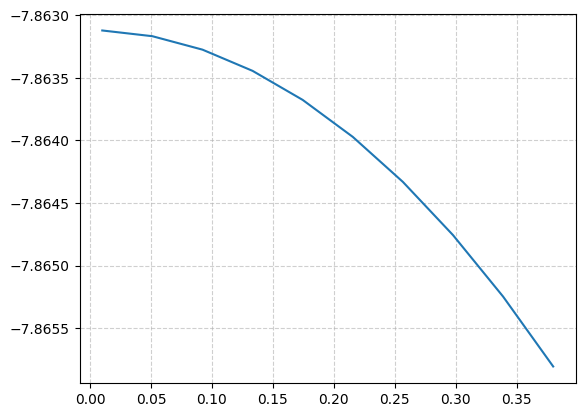

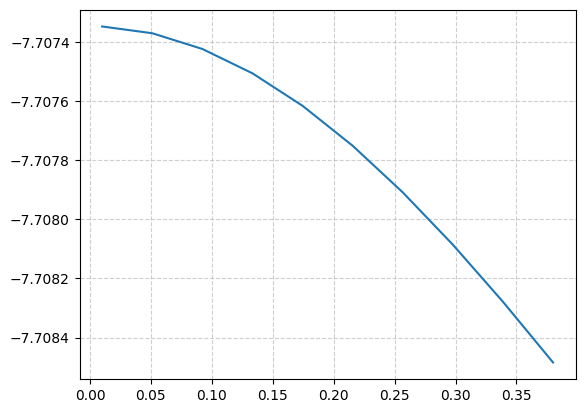

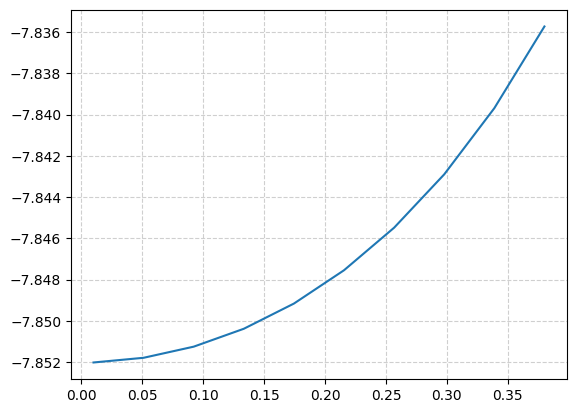

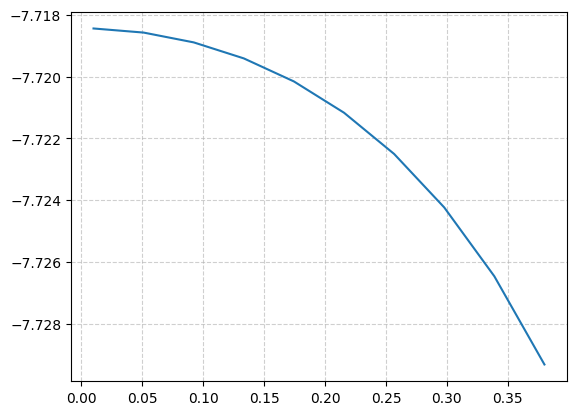

In [6]:
timesteps = np.linspace(0.01, 0.38, 10)
result = np.hstack([np.atleast_2d(sim_LiH.hamiltonian_t_mrsqk(t)).T for t in timesteps])

for r in result:
    plt.plot(timesteps, r)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

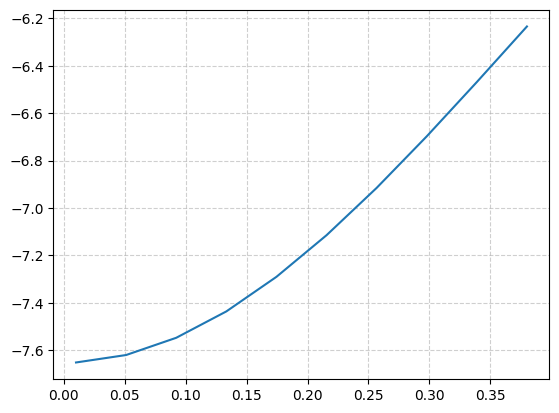

In [4]:
timesteps = np.linspace(0.01, 0.38, 10)
plt.plot(timesteps, [sim_LiH.hamiltonian_t_qdrift(t) for t in timesteps])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Larger Molecule Simulation
Here we aim to simulate larger (toxic) molecules like Cr(VI) for their ground and excited state energies to help with scientific understanding of the properties and effects of these molecules.

### Automatic Parameter Meta-Optimization
One innovation we made to be able to simulate larger molecules on our (underpowered) hardware was generating circuits with different parameters - primarily the different frozen orbitals in the molecule.

The algorithm clusters molecular orbitals based on their energies to generate efficient freeze lists for quantum chemical calculations. It uses k-means clustering (via dynamic programming (KMeans1D_DP)) to optimally partition the orbital energies into a specified number of clusters, minimizing the sum of squared deviations within each cluster.

By clustering both core (fully occupied) and virtual (unoccupied) orbitals, the generate_freeze_lists function creates groups of energetically similar orbitals. It then generates combinations of these clusters to produce various freeze lists, selecting clusters from the lowest energies for core orbitals and from the highest energies for virtual orbitals.

Exhaustively trying every possible combination of orbitals to freeze is computationally infeasible due to exponential scaling. Clustering provides a flexible and efficient alternative, allowing control over the number of clusters and the logic of grouping specific clusters based on energy levels. This method enables systematic exploration of freeze list options while keeping computational costs manageable.

A more thorough explanation of the method and implementation is shown in the `optimal_resources.ipynb` notebook, and implementations used here are in `qchem_opt.py`

First we define the Chromium(VI) ions we are interested in.

In [13]:
# Define the Cr element
Cr = [["Cr", (0, 0, 0)]]

# Create a SecondQuantizedMolecule instance for Cr_VI
Cr_VI = SecondQuantizedMolecule(Cr, q=6, spin=0, basis="LANL2DZ", frozen_orbitals=None)

# Create a SecondQuantizedMolecule instance for Cr_III
Cr_III = SecondQuantizedMolecule(Cr, q=3, spin=3, basis="LANL2DZ", frozen_orbitals=None)

print_molecule_properties("Cr_III", Cr_III)
print_molecule_properties("Cr_VI", Cr_VI)
print_orbital_energies(Cr_VI)

=== Cr_III Properties ===
Charge (q): 3
Spin (2S): 3
Number of Electrons: 21
Number of Active Electrons: 21
Basis Set: LANL2DZ
Frozen Orbitals: None
--------------------------

=== Cr_VI Properties ===
Charge (q): 6
Spin (2S): 0
Number of Electrons: 18
Number of Active Electrons: 18
Basis Set: LANL2DZ
Frozen Orbitals: None
--------------------------

Number of active electrons: 18

Orbital Index | Occupation Number | Orbital Energy (Hartree)
------------------------------------------------------------
0             2.0                -13.553112344568886
1             2.0                -10.761325068564085
2             2.0                -10.761325068564078
3             2.0                -10.761325068564076
4             2.0                -7.585325230169833
5             2.0                -7.585325230169831
6             2.0                -7.585325230169826
7             2.0                -7.585325230169826
8             2.0                -7.585325230169822
9             0.0    

Next we generate the lists of frozen electron orbitals we could use.

In [14]:
Cr_VI_freeze_lists = generate_freeze_lists(Cr_VI, 8, 4)

Number of active electrons: 18

Clustered core orbitals into 8 groups:
Core Cluster 1: Orbitals [0], Energies [-13.553112344568886]
Core Cluster 2: Orbitals [1], Energies [-10.761325068564085]
Core Cluster 3: Orbitals [2], Energies [-10.761325068564078]
Core Cluster 4: Orbitals [3], Energies [-10.761325068564076]
Core Cluster 5: Orbitals [4], Energies [-7.585325230169833]
Core Cluster 6: Orbitals [5], Energies [-7.585325230169831]
Core Cluster 7: Orbitals [6], Energies [-7.585325230169826]
Core Cluster 8: Orbitals [7 8], Energies [-7.585325230169826, -7.585325230169822]

Clustered virtual orbitals into 4 groups:
Virtual Cluster 1: Orbitals [9], Energies [-2.6196797450463283]
Virtual Cluster 2: Orbitals [10 11 12 13 14 15 16 17], Energies [-1.5292932133125963, -1.5292932133125952, -1.529293213312595, -1.5292932133125934, -1.5292932133125925, -1.4559799352676877, -1.4559799352676845, -1.4559799352676843]
Virtual Cluster 3: Orbitals [18], Energies [-1.2596576685724423]
Virtual Cluster 4: 

With our freeze lists ready, the next step is to estimate the quantum resources required for each configuration. We'll create a resources dictionary that maps each freeze list to its corresponding resource estimates, starting with the largest list of orbitals to freeze. This helps us analyze the feasibility of our simulations and check how far our backend can reach before the time limit alarm.

We'll perform this for the Cr_VI molecule. 

In [15]:
Cr_VI_resources_dict = create_resources_dict(
    mol=Cr, charge=6, mol_spin=0, freeze_lists=Cr_VI_freeze_lists, timeout_duration=3
)

Unexpected error for Freeze List 1: There are no active electrons.
Unexpected error for Freeze List 2: There are no active electrons.
Unexpected error for Freeze List 3: All active orbitals are fully occupied.
Unexpected error for Freeze List 4: All active orbitals are fully occupied.

Creating frozen molecule for Freeze List 5: [0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Unexpected error for Freeze List 6: All active orbitals are fully occupied.

Creating frozen molecule for Freeze List 7: [0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Unexpected error for Freeze List 8: All active orbitals are fully occupied.

Creating frozen molecule for Freeze List 9: [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Unexpected error for Freeze List 10: All active orbitals are fully occupied.

Creating frozen molecule for Freeze List 11: [0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Unexpected error for Freeze List 12: All a

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1101f97f0>>
Traceback (most recent call last):
  File "/Users/rohan/.pyenv/versions/3.12.5/envs/nyc_haq/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

  File "/Users/rohan/Developer/hack/nyc_haq/chem/quantum_chem/qchem_opt.py", line 212, in signal_handler
    raise TimeoutException("Timed out!")
qchem_opt.TimeoutException: Timed out!



Creating frozen molecule for Freeze List 20: [0, 1, 2, 3, 4, 5, 18, 19, 20, 21]
Function 'vqe_resources' timed out after 3 seconds.
Stopping at Freeze List [0, 1, 2, 3, 4, 5, 18, 19, 20, 21] due to timeout or error in resource calculation.

--- Frozen Molecules Dictionary ---
Index 0: {'molecule': SecondQuantizedMolecule(xyz=[('Cr', (0.0, 0.0, 0.0))], q=6, spin=0, solver=<tangelo.toolboxes.molecular_computation.integral_solver_pyscf.IntegralSolverPySCF object at 0x3338c1a90>, n_atoms=1, n_electrons=18, basis='LANL2DZ', ecp={}, symmetry=False, uhf=False, mf_energy=-300.1958062675419, mo_energies=array([-13.55311234, -10.76132507, -10.76132507, -10.76132507,
        -7.58532523,  -7.58532523,  -7.58532523,  -7.58532523,
        -7.58532523,  -2.61967975,  -1.52929321,  -1.52929321,
        -1.52929321,  -1.52929321,  -1.52929321,  -1.45597994,
        -1.45597994,  -1.45597994,  -1.25965767,  -0.65898474,
        -0.65898474,  -0.65898474]), mo_occ=array([2., 2., 2., 2., 2., 2., 2., 2.,

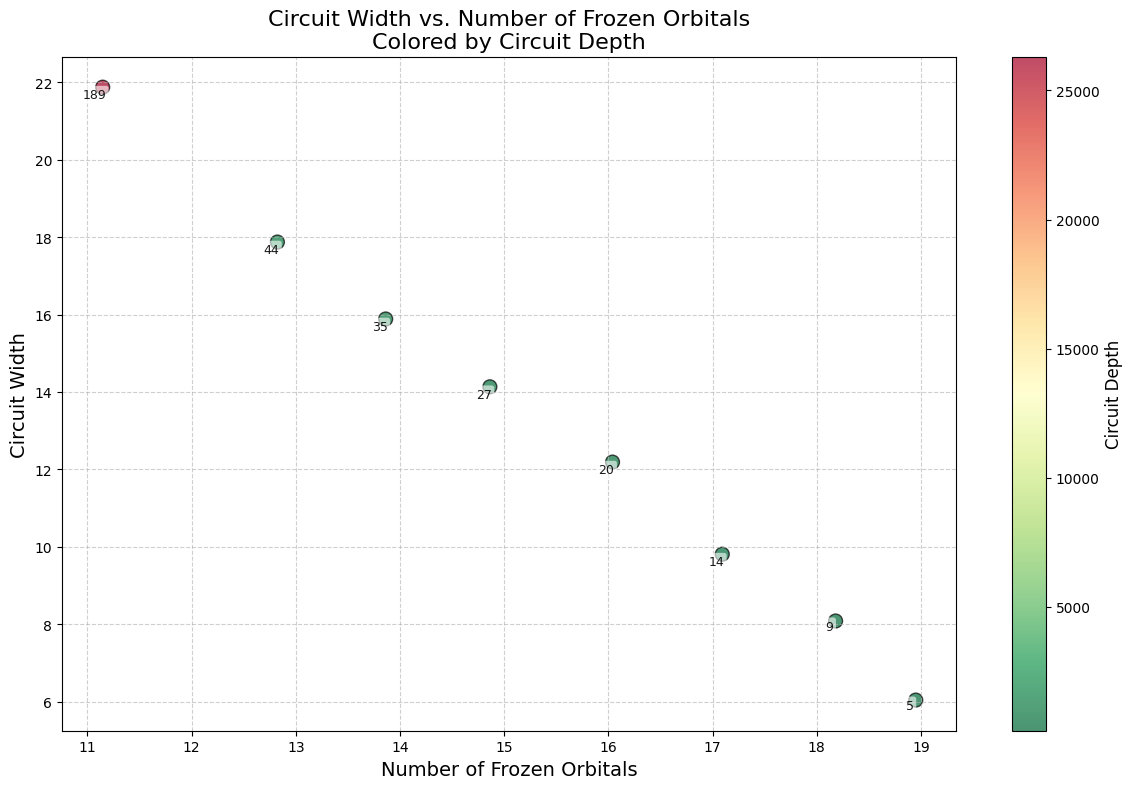

In [16]:
draw_resources(Cr_VI_resources_dict)

In [17]:
vqe_energies_vs_circuit_width = run_vqe_simulations(
    Cr_VI_resources_dict, timeout_duration=60
)

Running VQE simulation for circuit width 6
VQE simulation successful for circuit width 6. Energy: -300.19581408363814
Running VQE simulation for circuit width 8
VQE simulation successful for circuit width 8. Energy: -300.19581794597127
Running VQE simulation for circuit width 10
VQE simulation successful for circuit width 10. Energy: -300.1958217864105
Running VQE simulation for circuit width 12
VQE simulation successful for circuit width 12. Energy: -300.1958255964362
Running VQE simulation for circuit width 14
VQE simulation successful for circuit width 14. Energy: -300.19583249038664
Running VQE simulation for circuit width 16
VQE simulation successful for circuit width 16. Energy: -300.1958393331983
Running VQE simulation for circuit width 18
Function 'vqe_simulate' timed out after 60 seconds.
Stopping at circuit width 18 due to timeout.

Running classical simulation for the last successfully simulated molecule with circuit width 16
Classical energy for circuit width 16: -300.19583

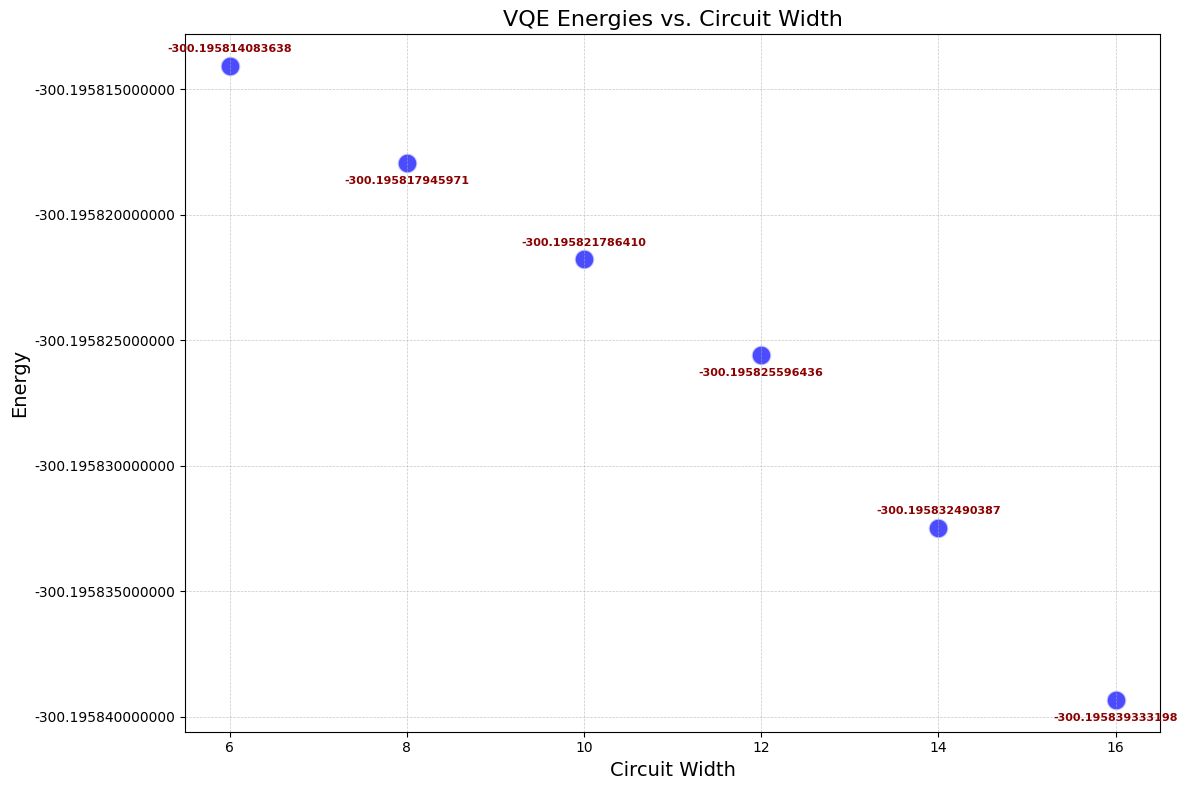

In [18]:
plot_energies_vs_circuit_width(vqe_energies_vs_circuit_width)

We can see here that with increasing circuit width/complexity, we get increasingly accurate results. Here, we get a ground state value of around -300.1958 for the Cr(VI) ion. This method of generating increasingly large circuits can be continued as larbitrarily long to improve the accuracy, based on the runtime constraints of your computer.

This method works on any general molecule, and gives us a resultant `SecondQuantizedMolecule` with the appropriate frozen orbitals. We can then use this in any of our implement simulation algorithms in our `MoleculeSimulator` or `HamiltonianSimulator` class for the ground/excited state energies and time simulation, respectively. We have implemented this for $NO_3^-$ and $Cr^{3+}$ in `optimal_resources.ipynb` in the repository.

## References
[1] Peruzzo, A., et al. (2014). A variational eigenvalue solver on a photonic quantum processor. Nature Communications, 5, 4213.

[2] Nakanishi, K. M., Mitarai, K., & Fujii, K. (2019). Subspace-search variational quantum eigensolver for excited states. Physical Review Research, 1(3), 033062.

[3] Higgott, O., Wang, D., & Brierley, S. (2019). Variational Quantum Computation of Excited States. Quantum, 3, 156.

[4] Huggins, W. J., et al. (2020). A Multireference Quantum Krylov Algorithm for Strongly Correlated Electrons. arXiv:1911.05163.

[5] Campbell, E. (2019). Random compiler for fast Hamiltonian simulation. Physical Review Letters, 123(7), 070503.
